In [2]:
import os
import neptune.new as neptune
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, MultiplicativeLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain
from tqdm.notebook import tqdm

# Set the Neptune Logger variables
NEPTUNE_API_TOKEN = os.environ.get('NEPTUNE_API_TOKEN')
NEPTUNE_PROJECT = os.environ.get('NEPTUNE_ALIAS') + '/2to2scattering'

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self):
        super(ModuleNetManual, self).__init__()
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function.
        """
        #x = x.cpu().detach().numpy().astype(np.float64)
        #return func_cust_torch(x)
        #return func_Bmin4half_approx(x)
        #return torch.tensor(np.array(func_Bmin4half_approx(x), dtype=np.float32), device=device)
        #return torch.tensor(np.array(func_Bmin8_approx(x), dtype=np.float32), device=device)
        return torch.sqrt(1.38065 + 3.1118 *x - 1.60815*torch.pow(x,2) - 4.731*torch.pow(x,3) + 6.58* torch.pow(x,4)) # Crichton example

In [4]:
def func_Bmin8(x):
    return np.abs((-1.052734802975798535925551891109149793786368463438e7+1j*3.28878036789629067312620825224461377108392741815e6) - (1.6703534215735708242031995615061086020359818640351*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**26)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**26 - ((172.95814240685473673198328013635502542943895967899+1j*-897.58137431044634566937433334925708974656942010281)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**25)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**25 + ((8619.826664603531566179905148951816033684148254281+1j*8290.9899325782890346643062005076249005590117638846)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**24)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**24 + ((43359.690526259801381050590987390891534946802126337+1j*-24853.399063796599629123326664272847037689933705983)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**23)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**23 - ((78702.90500171673920468132963958511241775487640836+1j*42503.39516062520866339215782968256749021756354023)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**22)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**22 + ((201394.3550042331419183082250258367558572089038719+1j*137811.4072519211350640756804342603786267864178188)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21 - ((558407.9902159505119873634835866969242331229001459+1j*106803.5110485095864179428531676339466957915054155)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20 + ((2.598074260120718738152921833864874779078391259445e6+1j*3.565936656487969881806304979264029029885713472168e6)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19 + ((1.035531660620034886465130155791904748454686625578e7+1j*-662552.657412831076252388998686963898567121926677)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18 + ((4.730846999167529113419525224052208242484744778188e7+1j*-2.663499116953354857820006855297913669051818569105e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17 - ((7.16623575863733069092135199796711184732987196306e7+1j*1.141826451546539106021545508933047378686342347677e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16 - ((1.63632681885593217136115356992327672010377740909e7+1j*-3.881734009821198138748022810818336231024625223075e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15 + ((7.48378879223411354274488044261966464416865017539e8+1j*-3.99061851925203200227535420373258254130787214636e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14 - ((2.872838954360461180829059704269547525319466831896e8+1j*2.908451432259038584514270481370469699589105672905e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13 + ((8.53182544257450202154464874007017569071055575461e7+1j*2.924136267590040074604417050461295922226804598669e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12 - ((5.23413418599826854703851536724279932022413891893e8+1j*3.98841464517205475527138330788536002760259657607e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11 + ((1.1058656931419510671280673069712802661672642434e8+1j*1.74005320063994445007224424445133735925070154182e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10 - ((3.92370084523891620169989709272442618907920370787e8+1j*1.8785172047023778917893323707680517217367741779e6)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9 + ((1.83949238182453079659711726010285249464227100906e8+1j*-2.17713278907514747301129294802197756389636599823e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8 - ((1.095659209568744340700861162668600125193337330861e8+1j*-2.28677377637253829795565194528644796961278331756e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7 + ((1.077742357197700614755266280963744160480188309119e8+1j*-2.7072744882979416269398501037713237964867578349e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6 - ((8.33857538230673575724418605923326140224994693691e7+1j*-2.61379279420039474146509172107339971274439545438e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5 + ((6.96394871024566977854686828497857793635174500335e7+1j*-2.14864175323239756610315545833222543581683654049e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4 - ((4.75926252010899873011622027715560834199550242102e7+1j*-1.61564014970249121257424868422144382778238883878e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3 + ((3.46795608901109110101342050289357768692857233109e7+1j*-1.05932235024429315738501664043910968071076947775e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2)/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2 - ((1.67224352103969983246119446626904386692749981935e7+1j*-5.23278763831462019997839540073379374554856800044e6)*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x))))/(2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x))) - (1.6703534215735708242031995615061086020359818640351*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**26)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**26 - ((172.95814240685473673198328013635502542943895967899+1j*-897.58137431044634566937433334925708974656942010281)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**25)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**25 + (916.09015403611113369511603938898484726844160040941*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**25)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**25) + ((8619.826664603531566179905148951816033684148254281+1j*8290.9899325782890346643062005076249005590117638846)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**24)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**24 - (9481.7937034418363098283146101600989399613884112532*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**24)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**24) + (4669.2386841937289468565047272683097549728132753457*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**24)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**24) + ((43359.690526259801381050590987390891534946802126337+1j*-24853.399063796599629123326664272847037689933705983)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**23)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**23 + (53231.425560630010295003255144100842874869344697407*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**23) - (14400.707165342297234082275911972817520839281582116*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**23) + (13588.220404764451346444417909983452408753132961746*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**23) - ((78702.90500171673920468132963958511241775487640836+1j*42503.39516062520866339215782968256749021756354023)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**22)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**22 - (183784.83160000794442359408622588620179804913800474*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**22) - (33940.540683545644775204806628608274939585788552437*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**22) - (73160.400923147310789673605877693850811437187309369*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**22) + (34111.575481080406536884300907717157038660664765825*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**22) + ((201394.3550042331419183082250258367558572089038719+1j*137811.4072519211350640756804342603786267864178188)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21 + (347645.76463396169603667784074505130140263302131483*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21) + (239278.76890928617435293176013912415687402227543554*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21) + (415957.01051523757121532808801333914038675987824035*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21) - (103065.61658845520243526706212714298178242947536538*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21) + (83046.117638433397321191600917655163323974125848971*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**21) - ((558407.9902159505119873634835866969242331229001459+1j*106803.5110485095864179428531676339466957915054155)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20 - (870120.13572696181022823329771363685486822354389888*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) + (360435.17415549568110650887017736717902512149882772*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) - (1.9415841343810966940303571459066073038424394847288e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) + (322642.75874198696457076935958925497266311792144834*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) - (670188.89736481998553560307225656880771936413245115*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) + (295987.53496376288018465651968789045698828784073625*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**20) + ((2.598074260120718738152921833864874779078391259445e6+1j*3.565936656487969881806304979264029029885713472168e6)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19 + (3.6117328622174159466278493332115771222542071634915e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) - (4.359535707657232553504732794590655486074657240699e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) + (6.1739286285652724153596457516260531226552020551774e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) - (2.4261473753976730136141696071646251423648758202428e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) + (4.2826946846985806365086422157772685254522563407747e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) - (2.1679533080279906912462426198452119927800339999388e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) + (1.2188341896412250264990227353347326045859640539029e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**19) + ((1.035531660620034886465130155791904748454686625578e7+1j*-662552.657412831076252388998686963898567121926677)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18 - (1.124005770979280027173328508932967093394112092664e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) + (1.7398641764894105993369724546351235313771189906634e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) - (2.2943024528116241055578659065806328310267034742672e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) + (2.0210189905263120405623895652603922826145201602114e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) - (2.3016577722323095998681545317161408264969249047163e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) + (1.4088371751513754894157248480910822750511679692103e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) - (1.0770085932122571915244464162619278939989894133908e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) + (5.1846886060756661134017933957597940676584228321589e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**18) + ((4.730846999167529113419525224052208242484744778188e7+1j*-2.663499116953354857820006855297913669051818569105e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17 + (4.2884752543848148339890731871158400909116656994662e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) - (9.0886978149005509656621114400002767684068208909201e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) + (1.2003715410287032514100797854525221860844573706643e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) - (1.2260081891455382561728625649448683579673632083338e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) + (1.1725062021993147289656597475802388801218068947673e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) - (8.9975656484381085674611359094317365626781451217953e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) + (7.4247408923194543756854346281576065810327946983146e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) - (4.7712431425200524827966873563443639076380551091006e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) + (2.4184014900762827844676839129279301056750075632129e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**17) - ((7.16623575863733069092135199796711184732987196306e7+1j*1.141826451546539106021545508933047378686342347677e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16 - (1.7039356978563261274606382176411481601629825830104e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) + (3.6724934791362295139263106917459143003110175008498e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) - (4.3235389338794116881679568478520851410021316643922e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) + (4.5200947760705812317430069159384562663740599981352e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) - (4.3605145846180727342011138559236494481414183169223e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) + (3.7764937919718680580457510375627414113531645374418e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) - (3.2165176048893294750557615507643868377947001087698e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) + (2.3580566257319391773732304720069228138001108465332e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) - (1.6027598555263196634681771769609851920921478214375e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) + (7.9501855869742085826993876807846254013133357395885e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**16) - ((1.63632681885593217136115356992327672010377740909e7+1j*-3.881734009821198138748022810818336231024625223075e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15 + (4.787372660369084960236707864843565125348129803242e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) - (8.7389735955358661818053484699434106807775352680463e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + (8.8876915596643529940090741506729485794883369448907e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) - (1.0268813640116296300370289378060285614553401853159e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + (1.0205463958275404458039630911002599061329285262732e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) - (9.26742676588271414672914258292531964604309079194e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + (8.1249362811377422388809945537990371353705688078359e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) - (6.4762309437379029525671935213018962693283221463772e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + (4.9897777226223440095242515939379315932462771936469e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) - (3.2874396086924572776430561775701691336559388490538e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + (1.6488284250315280239460215724695503929978764210534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**15) + ((7.48378879223411354274488044261966464416865017539e8+1j*-3.99061851925203200227535420373258254130787214636e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14 - (8.7922431134638095398080312718768518050651787700524e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (1.1478474948946356895393053595431528076849573839382e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - (1.0021155886183712950641546995576599057947475029258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (1.5168346093870657494571059281597114198174463500403e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - (1.3816827068038928910731301203735773974603030219069e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (1.2836042298682939107152094124230655986112502554695e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - (1.1719485282932096588271714800540276726608519179258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (9.8705335038526098313581332809218652782557951127876e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - (8.151671000780043230546248923797188771266953700143e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (6.0068530123179252910297088865246506061361393599079e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - (4.0586102964815663849991172608237301826339711998861e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) + (2.0178365787290685974953424084254456564523400668661e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**14) - ((2.872838954360461180829059704269547525319466831896e8+1j*2.908451432259038584514270481370469699589105672905e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13 + (1.0533003789349883602236276566242966845798475249792e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (5.6042295612004272202227108343613159909565242857802e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (4.97574235479993501095304453595116380000068682835e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (1.4226927165956733525539544128297104653109205735639e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (6.2796963338858583063514698322494254792027851098488e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (7.9683897375767604479151174884956655847606003586185e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (7.3947642314293585498957514306375324162114846024764e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (6.0101111183372478897476557521241320084839988662645e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (5.1917180724190886872027581413518689018617265135865e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (3.9837026130449407069662637724654425287413611614944e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (3.1531321988694761920030901524020230952060722682827e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) - (2.0379876331270830115325473668079127442536042380967e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + (1.0326642870087715697515129776175744694445760056163e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**13) + ((8.53182544257450202154464874007017569071055575461e7+1j*2.924136267590040074604417050461295922226804598669e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12 - (8.7922431134638095398080312718768518050651787700524e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (5.6042295612004272202227108343613159909565242857802e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (2.9104489934920619961164622704964289149635846751588e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (5.6070471156065180519300221121747672451263095571641e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (1.2682807274124435296158932905295442010173558798161e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (2.1644571698362278741392803202948962056908764373074e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (6.501337486972377791821636823604766899622210499263e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (7.0456251050234043517468785783268416601522686828283e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (5.9445213736567031658227007574950078514426404536152e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (5.3464862992959646368550570748474497127879560764309e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (4.1581413573274288419743025573962272326380794392085e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (3.3193188199546390128498040849324601616635368762056e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) + (2.1282782234559496694288798310040847763921271928751e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - (1.0771056711645234417897864108833897514748973031165e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**12) - ((5.23413418599826854703851536724279932022413891893e8+1j*3.98841464517205475527138330788536002760259657607e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11 + (4.787372660369084960236707864843565125348129803242e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (1.1478474948946356895393053595431528076849573839382e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (4.97574235479993501095304453595116380000068682835e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (5.6070471156065180519300221121747672451263095571641e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (2.5070734161551938908664626723383829763975712018564e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (4.1765310884586380099279739903692780271783131495447e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (2.2881650087444595157207266162480121318966076907791e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (1.8449203347712249487986725575165232102040006252658e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (1.6899500267708581777889787626768573762448052916441e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (1.6040592127286023044590005142559547981680901886841e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (1.3554387227796320918430776461316282279960968804933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (1.1185882041705722941991139730075731372129306673933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (8.2115795628660476160599057891068716330664496138585e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + (5.566270444353093413903201679312199845986958870154e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) - (2.7588747865450757538870091092245210568195272212417e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**11) + ((1.1058656931419510671280673069712802661672642434e8+1j*1.74005320063994445007224424445133735925070154182e8)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10 - (1.7039356978563261274606382176411481601629825830104e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (8.7389735955358661818053484699434106807775352680463e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (1.0021155886183712950641546995576599057947475029258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (1.4226927165956733525539544128297104653109205735639e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (1.2682807274124435296158932905295442010173558798161e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (4.1765310884586380099279739903692780271783131495447e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (3.077231657316402148845303516081736162182511485651e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (1.1391661560305644112049172935890852155166513361392e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (1.7914061610580616800872294667727597070751213441753e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (1.8135612813078164323581145846576554216243175127143e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (1.5434096920185476158083647406576608933914187211109e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (1.3450842498461727532937007113356253219837290366215e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (1.0705287550249418925304160304281458863090641508141e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (8.2870008911694481029663230326322371003251804722385e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) + (5.4113793747837865525699917796076780211784634424695e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - (2.7228817581579821229383653162914977532385112216093e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**10) - ((3.92370084523891620169989709272442618907920370787e8+1j*1.8785172047023778917893323707680517217367741779e6)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9 + (4.2884752543848148339890731871158400909116656994662e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (3.6724934791362295139263106917459143003110175008498e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (8.8876915596643529940090741506729485794883369448907e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (1.5168346093870657494571059281597114198174463500403e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (6.2796963338858583063514698322494254792027851098488e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (2.1644571698362278741392803202948962056908764373074e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (2.2881650087444595157207266162480121318966076907791e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (1.1391661560305644112049172935890852155166513361392e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (1.4731087168338477458259144086960598138146395582781e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (8.2132460515395781252019328457808260345325608119379e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (6.9977161782656644714979524015277763173348845366682e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (7.6522061352197862945027931104656736677151468738492e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (6.4169088143846256443875572724059991073971848137156e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (5.4075535518405676030800807568799088428352373385691e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (3.8323459776732285325535279974000122876187593705568e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + (2.6708352236161985942684709069087788175757919107637e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) - (1.3068972097017137771449423469011362814296534400355e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**9) + ((1.83949238182453079659711726010285249464227100906e8+1j*-2.17713278907514747301129294802197756389636599823e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8 - (1.124005770979280027173328508932967093394112092664e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (9.0886978149005509656621114400002767684068208909201e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (4.3235389338794116881679568478520851410021316643922e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (1.0268813640116296300370289378060285614553401853159e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (1.3816827068038928910731301203735773974603030219069e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (7.9683897375767604479151174884956655847606003586185e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (6.501337486972377791821636823604766899622210499263e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.8449203347712249487986725575165232102040006252658e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.7914061610580616800872294667727597070751213441753e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (8.2132460515395781252019328457808260345325608119379e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.014464468234367612864407807878856379513911861066e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (1.5230371687559010167528903418566746662657833305993e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.5518166656799277139058200884793590723073731591448e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (3.9934329935341974159337183691958106156084149278296e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.6966666411478974133569766034204734386001199917474e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (3.7570988758534869858491582411377166662885443417104e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) + (1.2087577318708339219034530348821597886348193371582e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - (8.5723849340514498410560925738535350921084350817328e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**8) - ((1.095659209568744340700861162668600125193337330861e8+1j*-2.28677377637253829795565194528644796961278331756e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7 + (3.6117328622174159466278493332115771222542071634915e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (1.7398641764894105993369724546351235313771189906634e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (1.2003715410287032514100797854525221860844573706643e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (4.5200947760705812317430069159384562663740599981352e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (1.0205463958275404458039630911002599061329285262732e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (1.2836042298682939107152094124230655986112502554695e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (7.3947642314293585498957514306375324162114846024764e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (7.0456251050234043517468785783268416601522686828283e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (1.6899500267708581777889787626768573762448052916441e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (1.8135612813078164323581145846576554216243175127143e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (6.9977161782656644714979524015277763173348845366682e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (1.5230371687559010167528903418566746662657833305993e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (2.6267777982319332121401392459462526851416317117613e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (9.6174179828876063805557709369896919156264180480844e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (1.0547438165922766833388223019320575873821704240534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (7.1085074283297271891717181801138881123210282684031e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (7.8478158258535387109979295056891747662406606318209e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) - (3.9649848265956674763680770801406422550332506781068e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + (2.2703982836784742913016999635229266367177657284541e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**7) + ((1.077742357197700614755266280963744160480188309119e8+1j*-2.7072744882979416269398501037713237964867578349e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6 - (870120.13572696181022823329771363685486822354389888*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (4.359535707657232553504732794590655486074657240699e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (2.2943024528116241055578659065806328310267034742672e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (1.2260081891455382561728625649448683579673632083338e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (4.3605145846180727342011138559236494481414183169223e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (9.26742676588271414672914258292531964604309079194e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (1.1719485282932096588271714800540276726608519179258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (6.0101111183372478897476557521241320084839988662645e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (5.9445213736567031658227007574950078514426404536152e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (1.6040592127286023044590005142559547981680901886841e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (1.5434096920185476158083647406576608933914187211109e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (7.6522061352197862945027931104656736677151468738492e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (1.5518166656799277139058200884793590723073731591448e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (9.6174179828876063805557709369896919156264180480844e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (5.9729114381001534590385596121513701076362955285505e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (3.1419508649832926614472295308003797677439213716618e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (4.0316639460930741697529902682655059923891397999779e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (7.8926148843065792374321335168854532566996162452618e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - (1.8333585576669880548974502950140391832712617281918e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) + (6.4849900041587383847995036089373432653099142986008e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**6) - ((8.33857538230673575724418605923326140224994693691e7+1j*-2.61379279420039474146509172107339971274439545438e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5 + (347645.76463396169603667784074505130140263302131483*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (360435.17415549568110650887017736717902512149882772*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (6.1739286285652724153596457516260531226552020551774e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (2.0210189905263120405623895652603922826145201602114e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (1.1725062021993147289656597475802388801218068947673e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (3.7764937919718680580457510375627414113531645374418e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (8.1249362811377422388809945537990371353705688078359e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (9.8705335038526098313581332809218652782557951127876e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (5.1917180724190886872027581413518689018617265135865e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (5.3464862992959646368550570748474497127879560764309e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (1.3554387227796320918430776461316282279960968804933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (1.3450842498461727532937007113356253219837290366215e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (6.4169088143846256443875572724059991073971848137156e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (3.9934329935341974159337183691958106156084149278296e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (1.0547438165922766833388223019320575873821704240534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (3.1419508649832926614472295308003797677439213716618e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) - (2.4245148065155601360502843500522817974473116164766e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (1.2379755914674701435344948450899657497534813852638e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (1.2392049054674866158156060949802085706745162584645e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (3.3174982418882930117229588915378933845711822713107e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + (1.124913610953316175270518194478199399489351503278e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**5) + ((6.96394871024566977854686828497857793635174500335e7+1j*-2.14864175323239756610315545833222543581683654049e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4 - (183784.83160000794442359408622588620179804913800474*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (239278.76890928617435293176013912415687402227543554*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (1.9415841343810966940303571459066073038424394847288e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (2.4261473753976730136141696071646251423648758202428e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (2.3016577722323095998681545317161408264969249047163e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (8.9975656484381085674611359094317365626781451217953e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (3.2165176048893294750557615507643868377947001087698e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (6.4762309437379029525671935213018962693283221463772e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (8.151671000780043230546248923797188771266953700143e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (3.9837026130449407069662637724654425287413611614944e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (4.1581413573274288419743025573962272326380794392085e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (1.1185882041705722941991139730075731372129306673933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (1.0705287550249418925304160304281458863090641508141e9*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (5.4075535518405676030800807568799088428352373385691e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (1.6966666411478974133569766034204734386001199917474e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (7.1085074283297271891717181801138881123210282684031e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (4.0316639460930741697529902682655059923891397999779e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (1.2379755914674701435344948450899657497534813852638e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (1.9958729518309767109281029934043019928925833276385e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (2.600297457756366573086854644640070007201141036188e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - (9.1156285456141635540111617867577383487988191439136e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) + (2.2642571882313539541242223141486943737637286089062e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**4) - ((4.75926252010899873011622027715560834199550242102e7+1j*-1.61564014970249121257424868422144382778238883878e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3 + (53231.425560630010295003255144100842874869344697407*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (33940.540683545644775204806628608274939585788552437*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (415957.01051523757121532808801333914038675987824035*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (322642.75874198696457076935958925497266311792144834*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (4.2826946846985806365086422157772685254522563407747e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (1.4088371751513754894157248480910822750511679692103e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (7.4247408923194543756854346281576065810327946983146e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (2.3580566257319391773732304720069228138001108465332e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (4.9897777226223440095242515939379315932462771936469e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (6.0068530123179252910297088865246506061361393599079e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (3.1531321988694761920030901524020230952060722682827e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (3.3193188199546390128498040849324601616635368762056e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (8.2115795628660476160599057891068716330664496138585e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (8.2870008911694481029663230326322371003251804722385e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (3.8323459776732285325535279974000122876187593705568e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (3.7570988758534869858491582411377166662885443417104e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (7.8478158258535387109979295056891747662406606318209e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (7.8926148843065792374321335168854532566996162452618e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (1.2392049054674866158156060949802085706745162584645e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (2.600297457756366573086854644640070007201141036188e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (1.6517139650206049147824821171842314323881381541339e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) - (2.6188504575208542198104482863144446092281513113848e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + (3.4015127573626253579924012803185779972039315504952e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**3) + ((3.46795608901109110101342050289357768692857233109e7+1j*-1.05932235024429315738501664043910968071076947775e7)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2 - (9481.7937034418363098283146101600989399613884112532*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**24*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**24*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (14400.707165342297234082275911972817520839281582116*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (73160.400923147310789673605877693850811437187309369*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (103065.61658845520243526706212714298178242947536538*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (670188.89736481998553560307225656880771936413245115*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (2.1679533080279906912462426198452119927800339999388e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (1.0770085932122571915244464162619278939989894133908e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (4.7712431425200524827966873563443639076380551091006e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (1.6027598555263196634681771769609851920921478214375e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (3.2874396086924572776430561775701691336559388490538e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (4.0586102964815663849991172608237301826339711998861e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (2.0379876331270830115325473668079127442536042380967e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (2.1282782234559496694288798310040847763921271928751e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (5.566270444353093413903201679312199845986958870154e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (5.4113793747837865525699917796076780211784634424695e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (2.6708352236161985942684709069087788175757919107637e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (1.2087577318708339219034530348821597886348193371582e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (3.9649848265956674763680770801406422550332506781068e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (1.8333585576669880548974502950140391832712617281918e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (3.3174982418882930117229588915378933845711822713107e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (9.1156285456141635540111617867577383487988191439136e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (2.6188504575208542198104482863144446092281513113848e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - (4.4930747164154181821806193958854704263577705217144e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) + (804507.1251316409881054288476237977379778016833496*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))**2) - ((1.67224352103969983246119446626904386692749981935e7+1j*-5.23278763831462019997839540073379374554856800044e6)*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x))) + (916.09015403611113369511603938898484726844160040941*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**25*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**25*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (4669.2386841937289468565047272683097549728132753457*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**24*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**24*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (13588.220404764451346444417909983452408753132961746*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (34111.575481080406536884300907717157038660664765825*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (83046.117638433397321191600917655163323974125848971*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (295987.53496376288018465651968789045698828784073625*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (1.2188341896412250264990227353347326045859640539029e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (5.1846886060756661134017933957597940676584228321589e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (2.4184014900762827844676839129279301056750075632129e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (7.9501855869742085826993876807846254013133357395885e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (1.6488284250315280239460215724695503929978764210534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (2.0178365787290685974953424084254456564523400668661e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (1.0326642870087715697515129776175744694445760056163e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) - (1.0771056711645234417897864108833897514748973031165e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) - (2.7588747865450757538870091092245210568195272212417e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) - (2.7228817581579821229383653162914977532385112216093e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) - (1.3068972097017137771449423469011362814296534400355e8*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) - (8.5723849340514498410560925738535350921084350817328e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (2.2703982836784742913016999635229266367177657284541e7*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (6.4849900041587383847995036089373432653099142986008e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (1.124913610953316175270518194478199399489351503278e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (2.2642571882313539541242223141486943737637286089062e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (3.4015127573626253579924012803185779972039315504952e6*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (804507.1251316409881054288476237977379778016833496*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))) + (438107.09753326361748895109315909686937971981045528*(2*np.sqrt(2/3) - np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(8 + 2*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 2*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(8 + 2*(-1 + x)))))/(32.*np.sqrt(2)*math.pi)

def func_Bmin8_approx(x):    
    return 1.3281546364990446 + 9.724245688762103e-11*x - 3.5483169174604567*np.power(x,2) - 6.893178632572615e-9*np.power(x,3) + 6.138374918921301*np.power(x,4) + 9.63071911526605e-8*np.power(x,5) -6.457502463672395*np.power(x,6) - 5.922171658753743e-7*np.power(x,7) + 138.42481185322234*np.power(x,8) + 1.97091659399145e-6*np.power(x,9) - 631.8740757275574*np.power(x,10) - 3.86654636352838e-6*np.power(x,11) + 1336.8062711901423*np.power(x,12) + 4.60101123995177e-6*np.power(x,13) - 1592.909044744137*np.power(x,14) - 3.2628677846045403e-6*np.power(x,15) + 1105.1958074334464*np.power(x,16) + 1.268005919680921e-6*np.power(x,17) - 418.17603594390454*np.power(x,18) - 2.0778512792331066e-7*np.power(x,19) + 66.87671320146404*np.power(x,20)

def func_Bmin4half(x):
    return 0.0033157279810811535*np.abs((1.9530888144128984e8+1j*-2.1660319323277983e8) - (1.6703534215735708242031995615061086020359818640351*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**26)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**26 + ((637.0584148461277+1j*668.0903962543763)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**25)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**25 + ((4629.269651824303+1j*-6057.326214567177)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**24)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**24 - ((28254.534365022413+1j*-29412.38385544641)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**23)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**23 + ((243891.24945746415+1j*-46362.00899970872)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**22)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**22 - ((683557.5965057976+1j*89745.18838963204)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21 + ((1.5875757013316199e6+1j*561415.6861413885)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20 - ((1.113681054738713e6+1j*889368.781716066)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19 + ((4.581672390625197e6+1j*-1.0386959581939303e6)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18 - ((2.8019857128431797e6+1j*-4.806458188454285e6)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17 + ((1.069240097257958e8+1j*2.176599347218904e7)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16 - ((8.314334204499066e7+1j*2.072504468169399e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15 + ((3.323550824309845e8+1j*7.38139979765137e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14 + ((1.401217834941659e8+1j*-1.6650185861347466e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13 - ((9.728596709763217e8+1j*-2.8357051539938736e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12 + ((1.9707658501183403e9+1j*-3.9428188461721897e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11 - ((3.40509872813657e9+1j*-4.706581095057391e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10 + ((3.8814781223072295e9+1j*-5.05236015405259e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9 - ((4.2049369892020674e9+1j*-5.028327217588801e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8 + ((4.119818168808688e9+1j*-4.722381663844211e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7 - ((3.744940439114106e9+1j*-4.2225539195587873e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6 + ((3.2293390097718196e9+1j*-3.601236965959257e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5 - ((2.621700263128874e9+1j*-2.912009062833463e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4 + ((1.9787692308358965e9+1j*-2.191317223757899e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3 - ((1.316992182464936e9+1j*-1.4605738706445103e9)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2)/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2 + ((6.577202654913011e8+1j*-7.294438537736062e8)*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x))))/(2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x))) - (1.6703534215735708242031995615061086020359818640351*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**26)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**26 + ((637.0584148461277+1j*668.0903962543763)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**25)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**25 + (916.09015403611113369511603938898484726844160040941*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**25)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**25) + ((4629.269651824303+1j*-6057.326214567177)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**24)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**24 - (9481.7937034418363098283146101600989399613884112532*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**24)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**24) + (4669.2386841937289468565047272683097549728132753457*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**24)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**24) - ((28254.534365022413+1j*-29412.38385544641)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**23)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**23 + (53231.425560630010295003255144100842874869344697407*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**23) - (14400.707165342297234082275911972817520839281582116*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**23) + (13588.220404764451346444417909983452408753132961746*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**23)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**23) + ((243891.24945746415+1j*-46362.00899970872)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**22)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**22 - (183784.83160000794442359408622588620179804913800474*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**22) - (33940.540683545644775204806628608274939585788552437*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**22) - (73160.400923147310789673605877693850811437187309369*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**22) + (34111.575481080406536884300907717157038660664765825*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**22)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**22) - ((683557.5965057976+1j*89745.18838963204)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21 + (347645.76463396169603667784074505130140263302131483*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21) + (239278.76890928617435293176013912415687402227543554*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21) + (415957.01051523757121532808801333914038675987824035*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21) - (103065.61658845520243526706212714298178242947536538*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21) + (83046.117638433397321191600917655163323974125848971*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**21)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**21) + ((1.5875757013316199e6+1j*561415.6861413885)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20 - (870120.13572696181022823329771363685486822354389888*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) + (360435.17415549568110650887017736717902512149882772*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) - (1.9415841343810966940303571459066073038424394847288e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) + (322642.75874198696457076935958925497266311792144834*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) - (670188.89736481998553560307225656880771936413245115*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) + (295987.53496376288018465651968789045698828784073625*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**20)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**20) - ((1.113681054738713e6+1j*889368.781716066)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19 + (3.6117328622174159466278493332115771222542071634915e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) - (4.359535707657232553504732794590655486074657240699e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) + (6.1739286285652724153596457516260531226552020551774e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) - (2.4261473753976730136141696071646251423648758202428e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) + (4.2826946846985806365086422157772685254522563407747e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) - (2.1679533080279906912462426198452119927800339999388e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) + (1.2188341896412250264990227353347326045859640539029e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**19)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**19) + ((4.581672390625197e6+1j*-1.0386959581939303e6)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18 - (1.124005770979280027173328508932967093394112092664e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) + (1.7398641764894105993369724546351235313771189906634e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) - (2.2943024528116241055578659065806328310267034742672e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) + (2.0210189905263120405623895652603922826145201602114e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) - (2.3016577722323095998681545317161408264969249047163e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) + (1.4088371751513754894157248480910822750511679692103e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) - (1.0770085932122571915244464162619278939989894133908e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) + (5.1846886060756661134017933957597940676584228321589e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**18)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**18) - ((2.8019857128431797e6+1j*-4.806458188454285e6)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17 + (4.2884752543848148339890731871158400909116656994662e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) - (9.0886978149005509656621114400002767684068208909201e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) + (1.2003715410287032514100797854525221860844573706643e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) - (1.2260081891455382561728625649448683579673632083338e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) + (1.1725062021993147289656597475802388801218068947673e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) - (8.9975656484381085674611359094317365626781451217953e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) + (7.4247408923194543756854346281576065810327946983146e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) - (4.7712431425200524827966873563443639076380551091006e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) + (2.4184014900762827844676839129279301056750075632129e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**17)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**17) + ((1.069240097257958e8+1j*2.176599347218904e7)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16 - (1.7039356978563261274606382176411481601629825830104e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) + (3.6724934791362295139263106917459143003110175008498e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) - (4.3235389338794116881679568478520851410021316643922e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) + (4.5200947760705812317430069159384562663740599981352e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) - (4.3605145846180727342011138559236494481414183169223e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) + (3.7764937919718680580457510375627414113531645374418e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) - (3.2165176048893294750557615507643868377947001087698e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) + (2.3580566257319391773732304720069228138001108465332e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) - (1.6027598555263196634681771769609851920921478214375e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) + (7.9501855869742085826993876807846254013133357395885e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**16)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**16) - ((8.314334204499066e7+1j*2.072504468169399e8)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15 + (4.787372660369084960236707864843565125348129803242e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) - (8.7389735955358661818053484699434106807775352680463e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + (8.8876915596643529940090741506729485794883369448907e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) - (1.0268813640116296300370289378060285614553401853159e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + (1.0205463958275404458039630911002599061329285262732e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) - (9.26742676588271414672914258292531964604309079194e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + (8.1249362811377422388809945537990371353705688078359e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) - (6.4762309437379029525671935213018962693283221463772e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + (4.9897777226223440095242515939379315932462771936469e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) - (3.2874396086924572776430561775701691336559388490538e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + (1.6488284250315280239460215724695503929978764210534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**15)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**15) + ((3.323550824309845e8+1j*7.38139979765137e8)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14 - (8.7922431134638095398080312718768518050651787700524e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (1.1478474948946356895393053595431528076849573839382e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) - (1.0021155886183712950641546995576599057947475029258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (1.5168346093870657494571059281597114198174463500403e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) - (1.3816827068038928910731301203735773974603030219069e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (1.2836042298682939107152094124230655986112502554695e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) - (1.1719485282932096588271714800540276726608519179258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (9.8705335038526098313581332809218652782557951127876e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) - (8.151671000780043230546248923797188771266953700143e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (6.0068530123179252910297088865246506061361393599079e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) - (4.0586102964815663849991172608237301826339711998861e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + (2.0178365787290685974953424084254456564523400668661e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**14)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**14) + ((1.401217834941659e8+1j*-1.6650185861347466e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13 + (1.0533003789349883602236276566242966845798475249792e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (5.6042295612004272202227108343613159909565242857802e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (4.97574235479993501095304453595116380000068682835e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (1.4226927165956733525539544128297104653109205735639e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (6.2796963338858583063514698322494254792027851098488e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (7.9683897375767604479151174884956655847606003586185e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (7.3947642314293585498957514306375324162114846024764e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (6.0101111183372478897476557521241320084839988662645e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (5.1917180724190886872027581413518689018617265135865e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (3.9837026130449407069662637724654425287413611614944e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (3.1531321988694761920030901524020230952060722682827e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - (2.0379876331270830115325473668079127442536042380967e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) + (1.0326642870087715697515129776175744694445760056163e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**13)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**13) - ((9.728596709763217e8+1j*-2.8357051539938736e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12 - (8.7922431134638095398080312718768518050651787700524e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (5.6042295612004272202227108343613159909565242857802e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (2.9104489934920619961164622704964289149635846751588e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (5.6070471156065180519300221121747672451263095571641e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (1.2682807274124435296158932905295442010173558798161e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (2.1644571698362278741392803202948962056908764373074e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (6.501337486972377791821636823604766899622210499263e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (7.0456251050234043517468785783268416601522686828283e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (5.9445213736567031658227007574950078514426404536152e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (5.3464862992959646368550570748474497127879560764309e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (4.1581413573274288419743025573962272326380794392085e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (3.3193188199546390128498040849324601616635368762056e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + (2.1282782234559496694288798310040847763921271928751e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) - (1.0771056711645234417897864108833897514748973031165e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**12)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**12) + ((1.9707658501183403e9+1j*-3.9428188461721897e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11 + (4.787372660369084960236707864843565125348129803242e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (1.1478474948946356895393053595431528076849573839382e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (4.97574235479993501095304453595116380000068682835e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (5.6070471156065180519300221121747672451263095571641e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (2.5070734161551938908664626723383829763975712018564e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (4.1765310884586380099279739903692780271783131495447e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (2.2881650087444595157207266162480121318966076907791e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (1.8449203347712249487986725575165232102040006252658e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (1.6899500267708581777889787626768573762448052916441e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (1.6040592127286023044590005142559547981680901886841e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (1.3554387227796320918430776461316282279960968804933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (1.1185882041705722941991139730075731372129306673933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (8.2115795628660476160599057891068716330664496138585e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) + (5.566270444353093413903201679312199845986958870154e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - (2.7588747865450757538870091092245210568195272212417e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**11)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**11) - ((3.40509872813657e9+1j*-4.706581095057391e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10 - (1.7039356978563261274606382176411481601629825830104e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (8.7389735955358661818053484699434106807775352680463e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (1.0021155886183712950641546995576599057947475029258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (1.4226927165956733525539544128297104653109205735639e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (1.2682807274124435296158932905295442010173558798161e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (4.1765310884586380099279739903692780271783131495447e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (3.077231657316402148845303516081736162182511485651e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (1.1391661560305644112049172935890852155166513361392e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (1.7914061610580616800872294667727597070751213441753e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (1.8135612813078164323581145846576554216243175127143e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (1.5434096920185476158083647406576608933914187211109e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (1.3450842498461727532937007113356253219837290366215e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (1.0705287550249418925304160304281458863090641508141e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (8.2870008911694481029663230326322371003251804722385e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + (5.4113793747837865525699917796076780211784634424695e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) - (2.7228817581579821229383653162914977532385112216093e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**10)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**10) + ((3.8814781223072295e9+1j*-5.05236015405259e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9 + (4.2884752543848148339890731871158400909116656994662e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (3.6724934791362295139263106917459143003110175008498e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (8.8876915596643529940090741506729485794883369448907e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (1.5168346093870657494571059281597114198174463500403e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (6.2796963338858583063514698322494254792027851098488e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (2.1644571698362278741392803202948962056908764373074e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (2.2881650087444595157207266162480121318966076907791e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (1.1391661560305644112049172935890852155166513361392e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (1.4731087168338477458259144086960598138146395582781e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (8.2132460515395781252019328457808260345325608119379e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (6.9977161782656644714979524015277763173348845366682e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (7.6522061352197862945027931104656736677151468738492e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (6.4169088143846256443875572724059991073971848137156e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (5.4075535518405676030800807568799088428352373385691e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (3.8323459776732285325535279974000122876187593705568e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) + (2.6708352236161985942684709069087788175757919107637e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - (1.3068972097017137771449423469011362814296534400355e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**9)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**9) - ((4.2049369892020674e9+1j*-5.028327217588801e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8 - (1.124005770979280027173328508932967093394112092664e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (9.0886978149005509656621114400002767684068208909201e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (4.3235389338794116881679568478520851410021316643922e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (1.0268813640116296300370289378060285614553401853159e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (1.3816827068038928910731301203735773974603030219069e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (7.9683897375767604479151174884956655847606003586185e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (6.501337486972377791821636823604766899622210499263e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.8449203347712249487986725575165232102040006252658e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.7914061610580616800872294667727597070751213441753e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (8.2132460515395781252019328457808260345325608119379e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.014464468234367612864407807878856379513911861066e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (1.5230371687559010167528903418566746662657833305993e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.5518166656799277139058200884793590723073731591448e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (3.9934329935341974159337183691958106156084149278296e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.6966666411478974133569766034204734386001199917474e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (3.7570988758534869858491582411377166662885443417104e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + (1.2087577318708339219034530348821597886348193371582e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) - (8.5723849340514498410560925738535350921084350817328e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**8)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**8) + ((4.119818168808688e9+1j*-4.722381663844211e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7 + (3.6117328622174159466278493332115771222542071634915e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (1.7398641764894105993369724546351235313771189906634e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (1.2003715410287032514100797854525221860844573706643e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (4.5200947760705812317430069159384562663740599981352e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (1.0205463958275404458039630911002599061329285262732e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (1.2836042298682939107152094124230655986112502554695e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (7.3947642314293585498957514306375324162114846024764e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (7.0456251050234043517468785783268416601522686828283e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (1.6899500267708581777889787626768573762448052916441e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (1.8135612813078164323581145846576554216243175127143e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (6.9977161782656644714979524015277763173348845366682e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (1.5230371687559010167528903418566746662657833305993e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (2.6267777982319332121401392459462526851416317117613e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (9.6174179828876063805557709369896919156264180480844e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (1.0547438165922766833388223019320575873821704240534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (7.1085074283297271891717181801138881123210282684031e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (7.8478158258535387109979295056891747662406606318209e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - (3.9649848265956674763680770801406422550332506781068e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) + (2.2703982836784742913016999635229266367177657284541e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**7)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**7) - ((3.744940439114106e9+1j*-4.2225539195587873e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6 - (870120.13572696181022823329771363685486822354389888*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (4.359535707657232553504732794590655486074657240699e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (2.2943024528116241055578659065806328310267034742672e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (1.2260081891455382561728625649448683579673632083338e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (4.3605145846180727342011138559236494481414183169223e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (9.26742676588271414672914258292531964604309079194e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (1.1719485282932096588271714800540276726608519179258e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (6.0101111183372478897476557521241320084839988662645e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (5.9445213736567031658227007574950078514426404536152e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (1.6040592127286023044590005142559547981680901886841e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (1.5434096920185476158083647406576608933914187211109e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (7.6522061352197862945027931104656736677151468738492e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (1.5518166656799277139058200884793590723073731591448e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (9.6174179828876063805557709369896919156264180480844e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (5.9729114381001534590385596121513701076362955285505e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (3.1419508649832926614472295308003797677439213716618e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (4.0316639460930741697529902682655059923891397999779e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (7.8926148843065792374321335168854532566996162452618e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) - (1.8333585576669880548974502950140391832712617281918e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + (6.4849900041587383847995036089373432653099142986008e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**6)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**6) + ((3.2293390097718196e9+1j*-3.601236965959257e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5 + (347645.76463396169603667784074505130140263302131483*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (360435.17415549568110650887017736717902512149882772*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (6.1739286285652724153596457516260531226552020551774e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (2.0210189905263120405623895652603922826145201602114e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (1.1725062021993147289656597475802388801218068947673e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (3.7764937919718680580457510375627414113531645374418e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (8.1249362811377422388809945537990371353705688078359e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (9.8705335038526098313581332809218652782557951127876e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (5.1917180724190886872027581413518689018617265135865e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (5.3464862992959646368550570748474497127879560764309e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (1.3554387227796320918430776461316282279960968804933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (1.3450842498461727532937007113356253219837290366215e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (6.4169088143846256443875572724059991073971848137156e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (3.9934329935341974159337183691958106156084149278296e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (1.0547438165922766833388223019320575873821704240534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (3.1419508649832926614472295308003797677439213716618e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - (2.4245148065155601360502843500522817974473116164766e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (1.2379755914674701435344948450899657497534813852638e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (1.2392049054674866158156060949802085706745162584645e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (3.3174982418882930117229588915378933845711822713107e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) + (1.124913610953316175270518194478199399489351503278e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**5)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**5) - ((2.621700263128874e9+1j*-2.912009062833463e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4 - (183784.83160000794442359408622588620179804913800474*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (239278.76890928617435293176013912415687402227543554*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (1.9415841343810966940303571459066073038424394847288e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (2.4261473753976730136141696071646251423648758202428e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (2.3016577722323095998681545317161408264969249047163e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (8.9975656484381085674611359094317365626781451217953e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (3.2165176048893294750557615507643868377947001087698e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (6.4762309437379029525671935213018962693283221463772e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (8.151671000780043230546248923797188771266953700143e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (3.9837026130449407069662637724654425287413611614944e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (4.1581413573274288419743025573962272326380794392085e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (1.1185882041705722941991139730075731372129306673933e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (1.0705287550249418925304160304281458863090641508141e9*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (5.4075535518405676030800807568799088428352373385691e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (1.6966666411478974133569766034204734386001199917474e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (7.1085074283297271891717181801138881123210282684031e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (4.0316639460930741697529902682655059923891397999779e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (1.2379755914674701435344948450899657497534813852638e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (1.9958729518309767109281029934043019928925833276385e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (2.600297457756366573086854644640070007201141036188e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) - (9.1156285456141635540111617867577383487988191439136e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + (2.2642571882313539541242223141486943737637286089062e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**4)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**4) + ((1.9787692308358965e9+1j*-2.191317223757899e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3 + (53231.425560630010295003255144100842874869344697407*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (33940.540683545644775204806628608274939585788552437*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (415957.01051523757121532808801333914038675987824035*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (322642.75874198696457076935958925497266311792144834*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (4.2826946846985806365086422157772685254522563407747e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (1.4088371751513754894157248480910822750511679692103e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (7.4247408923194543756854346281576065810327946983146e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (2.3580566257319391773732304720069228138001108465332e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (4.9897777226223440095242515939379315932462771936469e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (6.0068530123179252910297088865246506061361393599079e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (3.1531321988694761920030901524020230952060722682827e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (3.3193188199546390128498040849324601616635368762056e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (8.2115795628660476160599057891068716330664496138585e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (8.2870008911694481029663230326322371003251804722385e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (3.8323459776732285325535279974000122876187593705568e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (3.7570988758534869858491582411377166662885443417104e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (7.8478158258535387109979295056891747662406606318209e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (7.8926148843065792374321335168854532566996162452618e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (1.2392049054674866158156060949802085706745162584645e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (2.600297457756366573086854644640070007201141036188e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (1.6517139650206049147824821171842314323881381541339e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - (2.6188504575208542198104482863144446092281513113848e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) + (3.4015127573626253579924012803185779972039315504952e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**3)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**3) - ((1.316992182464936e9+1j*-1.4605738706445103e9)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2 - (9481.7937034418363098283146101600989399613884112532*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**24*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**24*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (14400.707165342297234082275911972817520839281582116*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (73160.400923147310789673605877693850811437187309369*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (103065.61658845520243526706212714298178242947536538*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (670188.89736481998553560307225656880771936413245115*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (2.1679533080279906912462426198452119927800339999388e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (1.0770085932122571915244464162619278939989894133908e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (4.7712431425200524827966873563443639076380551091006e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (1.6027598555263196634681771769609851920921478214375e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (3.2874396086924572776430561775701691336559388490538e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (4.0586102964815663849991172608237301826339711998861e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (2.0379876331270830115325473668079127442536042380967e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (2.1282782234559496694288798310040847763921271928751e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (5.566270444353093413903201679312199845986958870154e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (5.4113793747837865525699917796076780211784634424695e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (2.6708352236161985942684709069087788175757919107637e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (1.2087577318708339219034530348821597886348193371582e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (3.9649848265956674763680770801406422550332506781068e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (1.8333585576669880548974502950140391832712617281918e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (3.3174982418882930117229588915378933845711822713107e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (9.1156285456141635540111617867577383487988191439136e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (2.6188504575208542198104482863144446092281513113848e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) - (4.4930747164154181821806193958854704263577705217144e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + (804507.1251316409881054288476237977379778016833496*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x)))**2)/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))**2) + ((6.577202654913011e8+1j*-7.294438537736062e8)*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x))) + (916.09015403611113369511603938898484726844160040941*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**25*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**25*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (4669.2386841937289468565047272683097549728132753457*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**24*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**24*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (13588.220404764451346444417909983452408753132961746*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**23*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (34111.575481080406536884300907717157038660664765825*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**22*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (83046.117638433397321191600917655163323974125848971*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**21*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (295987.53496376288018465651968789045698828784073625*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**20*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (1.2188341896412250264990227353347326045859640539029e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**19*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (5.1846886060756661134017933957597940676584228321589e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**18*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (2.4184014900762827844676839129279301056750075632129e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**17*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (7.9501855869742085826993876807846254013133357395885e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**16*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (1.6488284250315280239460215724695503929978764210534e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**15*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (2.0178365787290685974953424084254456564523400668661e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**14*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (1.0326642870087715697515129776175744694445760056163e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**13*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) - (1.0771056711645234417897864108833897514748973031165e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**12*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) - (2.7588747865450757538870091092245210568195272212417e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**11*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) - (2.7228817581579821229383653162914977532385112216093e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**10*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) - (1.3068972097017137771449423469011362814296534400355e8*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**9*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) - (8.5723849340514498410560925738535350921084350817328e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**8*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (2.2703982836784742913016999635229266367177657284541e7*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**7*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (6.4849900041587383847995036089373432653099142986008e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**6*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (1.124913610953316175270518194478199399489351503278e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**5*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (2.2642571882313539541242223141486943737637286089062e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**4*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (3.4015127573626253579924012803185779972039315504952e6*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**3*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (804507.1251316409881054288476237977379778016833496*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))**2*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))) + (438107.09753326361748895109315909686937971981045528*(2*np.sqrt(2/3) - np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) - np.sqrt(4.5 + 0.25*(-1 + x))))/((2*np.sqrt(2/3) + np.sqrt(4 - 0.25*(-1 + x)))*(2*np.sqrt(2/3) + np.sqrt(4.5 + 0.25*(-1 + x)))))

def func_Bmin4half_approx(x):
    return 0.490866 + 7.24091*1e-11*x + 0.198204*np.power(x,2) - 5.75247*1e-10*np.power(x,3) + 0.0207012*np.power(x,4) + 7.17144*1e-10*np.power(x,5) - 0.00735458*np.power(x,6) + 2.46948*1e-10*np.power(x,7) + 0.00141426*np.power(x,8) 
    
def func_cust(x):
    return np.sqrt(0.1864177889543183 + 0.41647376685909526*x + 0.8377156921351308*np.power(x,2)- 1.0316161422225043*np.power(x,3)+ 1.5492786732881514*np.power(x,4)+ 3.3910856858790934*np.power(x,5)+ 0.9457505328275536*np.power(x,6)- 21.63236072288463*np.power(x,7)+ 9.350153316771227*np.power(x,8)+ 52.23099394586682*np.power(x,9)- 19.299051482253137*np.power(x,10) - 118.44644869351315*np.power(x,11) + 34.20574133615336*np.power(x,12) + 229.9431170236456*np.power(x,13) - 79.43972859403297*np.power(x,14) - 298.74282823044416*np.power(x,15) + 136.49153479837958*np.power(x,16) + 210.28596923351665*np.power(x,17) - 113.44867289186665*np.power(x,18) - 66.31469285679069*np.power(x,19) + 41.00235242693725*np.power(x,20))

In [5]:
def func_cust_torch(x):
    return torch.sqrt(0.1864177889543183 + 0.41647376685909526*x + 0.8377156921351308*torch.pow(x,2)- 1.0316161422225043*torch.pow(x,3)+ 1.5492786732881514*torch.pow(x,4)+ 3.3910856858790934*torch.pow(x,5)+ 0.9457505328275536*torch.pow(x,6)- 21.63236072288463*torch.pow(x,7)+ 9.350153316771227*torch.pow(x,8)+ 52.23099394586682*torch.pow(x,9)- 19.299051482253137*torch.pow(x,10) - 118.44644869351315*torch.pow(x,11) + 34.20574133615336*torch.pow(x,12) + 229.9431170236456*torch.pow(x,13) - 79.43972859403297*torch.pow(x,14) - 298.74282823044416*torch.pow(x,15) + 136.49153479837958*torch.pow(x,16) + 210.28596923351665*torch.pow(x,17) - 113.44867289186665*torch.pow(x,18) - 66.31469285679069*torch.pow(x,19) + 41.00235242693725*torch.pow(x,20))

In [18]:
def cust_sigmoidal(z, end_low=-math.pi, end_high=math.pi, slope_fact=5):
    range_diff = (end_high-end_low)/2
    range_tot = (end_high+end_low)/2
    
    return range_diff* torch.sigmoid(slope_fact*(z-range_tot)) +range_tot

class Custom_Sigmoid(nn.Module):
    def __init__(self, slope_sigmoid=10):
        super(Custom_Sigmoid, self).__init__()
        self.slope_sigmoid = slope_sigmoid
        #self.slope_sigmoid = slope_sigmoid * torch.nn.Parameter(torch.ones(1)) # If we want to learn the slope
    
    def forward(self, z):
        return cust_sigmoidal(z, slope_fact=self.slope_sigmoid)

In [19]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, device='cpu', final_layer='Sigmoid'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation function '{}' not supported. Supported activation functions are 'ReLU' and 'Tanh'".format(activation))

        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        elif final_layer == 'Custom_Sigmoid':
            self.final_layer = Custom_Sigmoid()
            self.final_l = 'Custom_Sigmoid'
        elif final_layer == 'Identity':
            self.final_layer = nn.Identity()
            self.final_l = 'Identity'
        else:
            raise ValueError("Final layer '{}' not supported. Supported final layers are 'Sigmoid', 'Tanh' and 'Identity'".format(final_layer))

        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi, pi]
        """
        #x = (x+1)/2 # Normalize the the cosine input variable
        x = self.model(x)
        if self.final_l == 'Identity' or self.final_l == 'Custom_Sigmoid':
            return x
        if self.final_l == 'Sigmoid':
            return 2*math.pi*x - math.pi
        elif self.final_l == 'Tanh':
            return math.pi*x
        else:
            raise ValueError('No good activation function')
    

class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.repulsive_epochs = params_simu['repulsive_epochs']
        self.loss_func = params_simu['loss']
        
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator

        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = self.mod_net(z1_points).view(1,-1,1)*self.mod_net(self.z2(z, z1_points, phi_points))*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        target = torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        
        model_input = self.integral_approximator(zsamples, method=self.method_int)
        
        # If scaled then all targets should be sin phase
        if self.scaled_loss:
             model_input = model_input / (self.mod_net(zsamples))
            
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out
    
    def multi_loss_function(self, zsamples, logger=None):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            logger['metrics/solution_loss_{}'.format(i)].log(individual_loss)
            total_loss = total_loss + individual_loss
        
        return total_loss
    
    def dual_loss(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        target = torch.stack((torch.cos(self.multi_nets[0](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[0](zsamples.view(-1,1)).squeeze())))
        model_input = torch.stack((torch.cos(self.multi_nets[1](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[1](zsamples.view(-1,1)).squeeze())))
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out = torch.pow(F.mse_loss(model_input, target), -self.p_value)
        
        return loss_out
    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        net1_val = self.multi_nets[0](zsamples.view(-1,1)).squeeze()
        net2_val = self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        target = torch.stack((torch.cos(net1_val), torch.sin(net1_val)))
        model_input1 = torch.stack((torch.cos(net2_val), torch.sin(net2_val)))
        model_input2 = torch.stack((-torch.cos(net2_val), torch.sin(net2_val)))
        
            
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        #loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
        #loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)
        
        loss_out1 = 1-torch.tanh(self.p_value * F.mse_loss(model_input1, target))
        loss_out2 = 1-torch.tanh(self.p_value * F.mse_loss(model_input2, target))
        
        return loss_out1 + loss_out2
        
    def complete_loss(self, zsamples, dual_active, logger=None):
        
        if not self.multiple_nets:
            return self.loss_function(zsamples)
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            logger['metrics/repulsive_loss'].log(repulsive_loss)
            
            unitarity_loss = self.multi_loss_function(zsamples, logger=logger)
            
            if repulsive_loss * 10 > unitarity_loss and self.lambda_repulsive>0.0:
            
                return unitarity_loss + self.lambda_repulsive * repulsive_loss
            else:
                return unitarity_loss
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input = model_input / (self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()))
        return torch.square(model_input - target)
        
    def train(self, neptune_run):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        p_value_init = self.p_value
        tq_iterator = tqdm(range(self.epochs), unit='epoch')
        
        for epoch_num in tq_iterator:
            
            #dual_active = False if epoch_num < 0.1*self.epochs or epoch_num > 0.2*self.epochs else True
            dual_active = True
            self.p_value = repulsive_decay_func(p_value_init, epoch_num, self.repulsive_epochs)
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            
            if self.device is not torch.device('cuda'):
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            else:
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp
                
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                loss.backward()
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step()
                
            if self.scheduler is not None:
                self.scheduler.step()
            neptune_run['metrics/train_loss'].log(loss)
            
            tq_iterator.set_description('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num,loss.item()))

def scheduler_rate(step, factor, size_param, warmup):
    """
    For the Learning Rate scheduler we implement a warmup start, followed by a square root decay
    """
    if step == 0:
        step = 1
    return factor * size_param**(-0.5) * min(step**(-0.5), step*warmup ** (-1.5))

def scheduler_rate_exp(step, gamma, max_ep):
    """
    For the Exponential Learning Rate scheduler where we decay only after the repulsive loss
    
    # Should probably do this with MultiplicativeLR instead
    """
    if step < 0.3 * max_ep:
        return 1
    else:
        return gamma

In [20]:
def repulsive_decay_func(p_value_init, epoch_num, repulsive_epochs, overall_scale=8):
    """
    Construct a profile function for the increase in the temperature parameter used
    in the repulsive loss
    """
    
    # Construct a hyperbolic tanh function with a maximum slope at the middle of the repulsive interval
    # The hyperbolic function reaches 0.9 at the end of the repulsive interval
    a = (repulsive_epochs[0] + repulsive_epochs[1])/(2*math.atanh(0.9))
    b = (repulsive_epochs[1] - repulsive_epochs[0])/(2*a)
    
    # Scale the init value by 1 at 0 and by the overall_scale at the end
    scale1 = (1-overall_scale)/(math.tanh(-b) - 1)
    
    return p_value_init*(math.tanh(-b + epoch_num/a)*scale1 + overall_scale - scale1)

In [21]:
from torchinfo import summary

def train_run(parameters, device, run_neptune, module_net=None, phi_net=None, seed_num=42, optim_name='Adam'):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer']) for i in range(num_phi_nets)]
        phidisp = phinn[0]
    else:
        if phi_net is None:
            phinn = PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer'])
        else:
            phinn = phi_net
        phidisp = phinn
    

    run_neptune["config/phimodel"] = type(phidisp).__name__
    with open(f"model_arch.txt", "w") as f:
        f.write(str(summary(phidisp, verbose=0, col_width=16, device=device)))
        f.write(str(phidisp))
    print(str(phidisp))
    
    if module_net is None:
        modnn = ModuleNetManual()
    else:
        modnn = module_net
    run_neptune["config/modmodel"] = type(modnn).__name__
    
    run_neptune["model_arch"].upload("model_arch.txt")
    
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
        else:
            optimizer = torch.optim.LBFGS(phinn.parameters(), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
            
    run_neptune["config/optimizer"] = type(optimizer).__name__
    
    
    if parameters['lr_scheduler']:
        #lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.9995)
        lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num']))
        #lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate(step, 1/parameters['learning_rate'], 2048, 750))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train(run_neptune)

    return netsolver

In [22]:
def eval_run(trained_solver, params, device, neptune_run, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_scaled' + str_add].log(eval_loss_scaled)
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_base' + str_add].log(eval_loss_base)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

##### Plot the relevant differential cross section

In [11]:
net_mod = ModuleNetManual()

In [12]:
z_pointst = torch.linspace(-1,1,steps=1000, device=device)

In [13]:
net_b = net_mod(z_pointst)


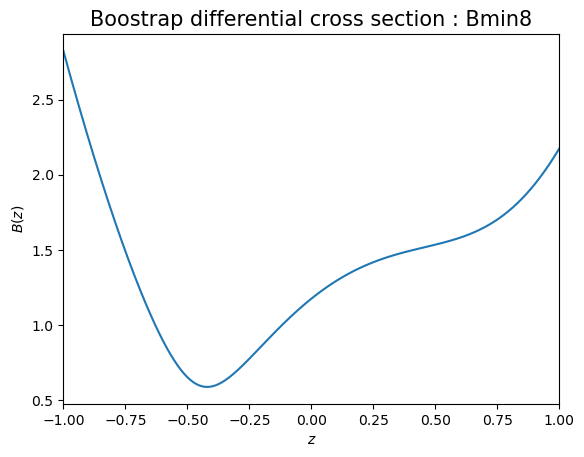

In [14]:
import matplotlib.pyplot as plt
plt.plot(z_pointst.cpu(), net_b.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : Bmin8', fontsize = 15)
plt.xlim([-1,1])
plt.show()

In [15]:
def z2comp(z, z1, phi):
    """
    Compute the z2 parameter (formula in motivation)
    Place the batch size on first dim, z1 on the second and phi on the third
    """
    term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
    term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
    return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    

z1_points = torch.linspace(-1,1,steps=150, device=device)
phi_points = torch.linspace(0, 2*math.pi, steps=150, device=device)
dx_z1 = 2/(150-1)
dx_phi = 2*math.pi/(150-1)

grid_points = net_mod(z1_points).view(1,-1,1)*net_mod(z2comp(z_pointst, z1_points, phi_points))

integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 

torch.max(integral/net_mod(z_pointst))

/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136169395/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor(3.2363, device='mps:0')

##### The precision used matters a lot here

To get the following cells, delete the astype(np.float64) in the ManualModuleNet

We can see that if we pass a float32 array then we do not recover the correct values at all
We must really explicitly convert the array to a float64 first

In [16]:
print(func_Bmin4half(torch.tensor([ 9.5000e-01], device=torch.device('cpu'), dtype=torch.float64).cpu().detach().numpy()))
print(func_Bmin4half(torch.tensor([ 9.5000e-01], device=torch.device('cpu')).cpu().detach().numpy()))
print(func_Bmin4half(torch.tensor([ 9.5000e-01], device=torch.device('mps')).cpu().detach().numpy()))
print(func_Bmin4half(torch.tensor([ 9.5000e-01], device=torch.device('cpu')).cpu().detach().numpy().astype(np.float64)))
print(func_Bmin4half(torch.tensor([ 9.5000e-01], device=torch.device('mps')).cpu().detach().numpy().astype(np.float64)))

[0.68214104]
[0.29398417]
[0.29398417]
[0.68214104]
[0.68214104]


##### Now can do the run

In [23]:
import matplotlib.pyplot as plt
from neptune.new.types import File


def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)

def plot_phase(zpoints, phipoints, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), np.log10(point_loss_data_no_s.cpu()), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints, tags_run):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    #plt.ylim([-3.14,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

In [157]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_B10")

params = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': [0, 1000],
         'lr_scheduler': False, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': True,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

tags = {'constant function': 'Run_B10', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-1726
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [158]:
netsolver = train_run(params, device, run, seed_num=42, optim_name='Adam')

PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)


  0%|          | 0/5000 [00:00<?, ?epoch/s]

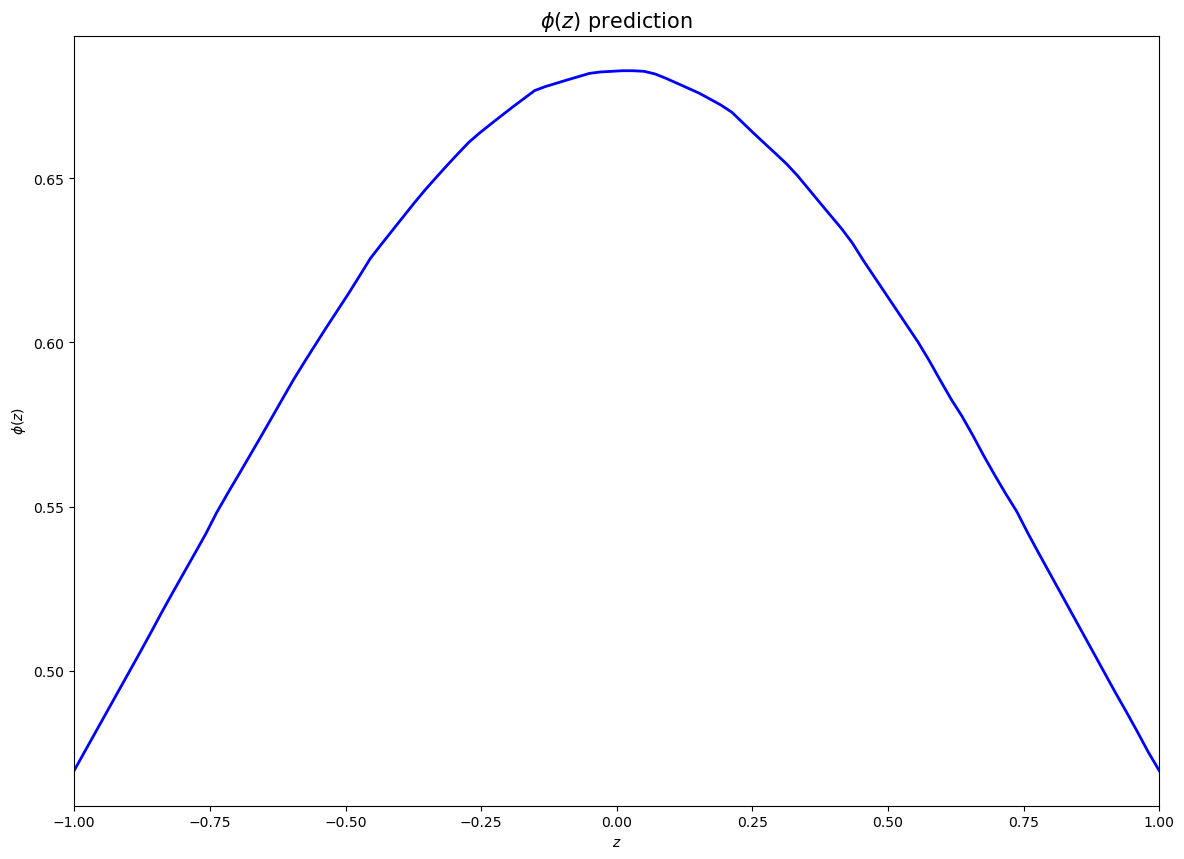

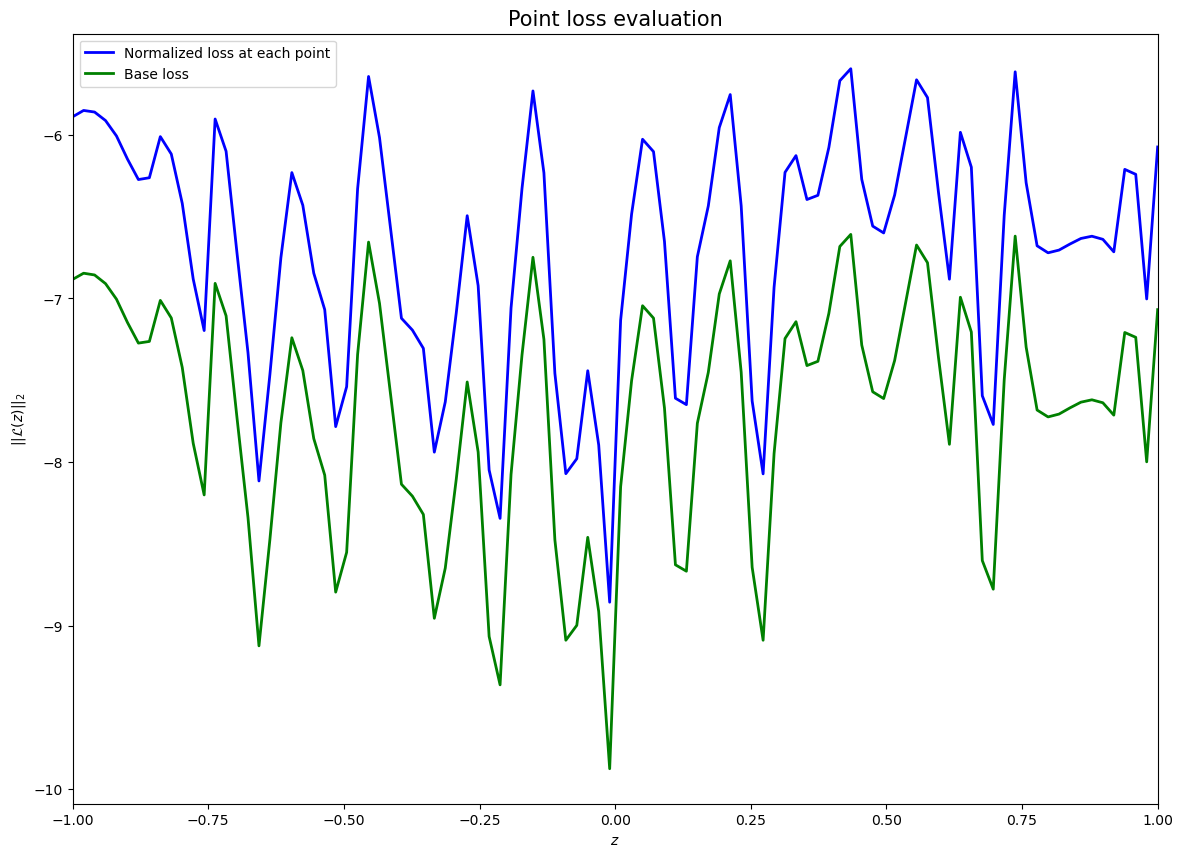

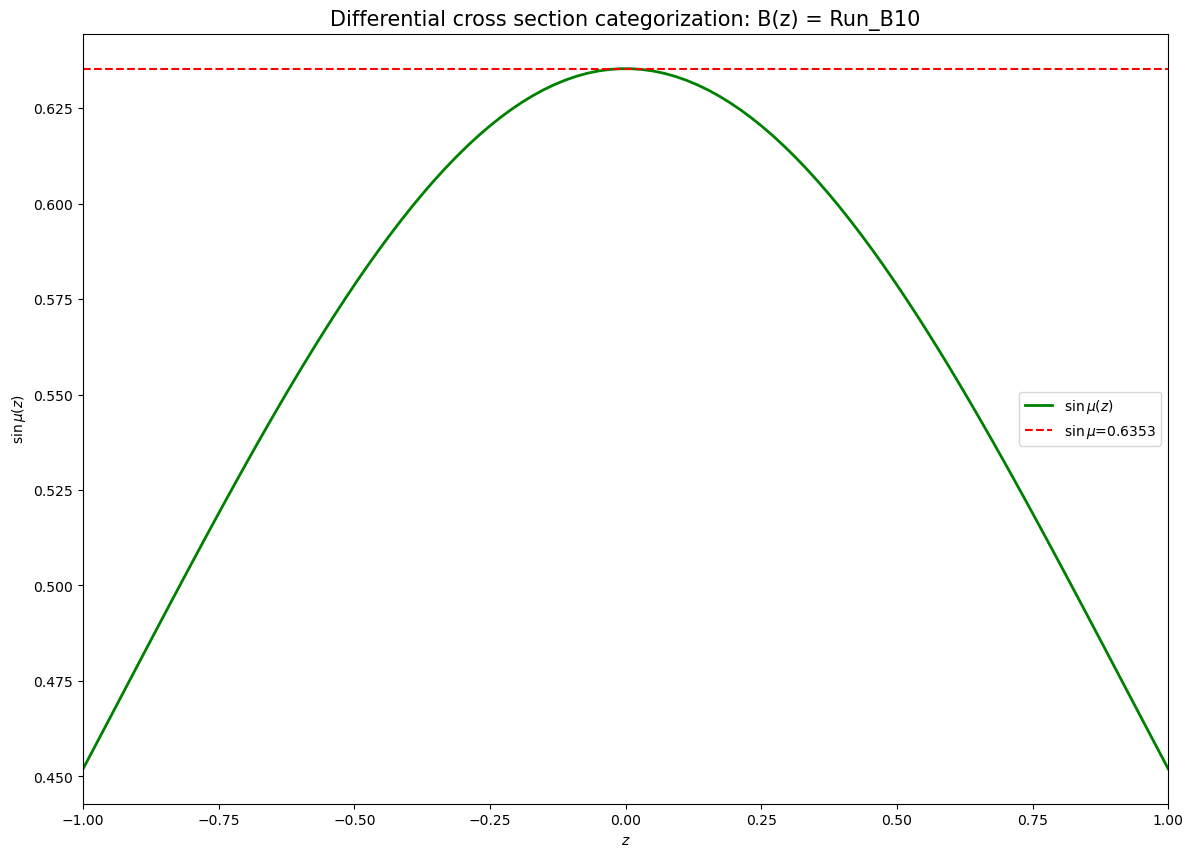

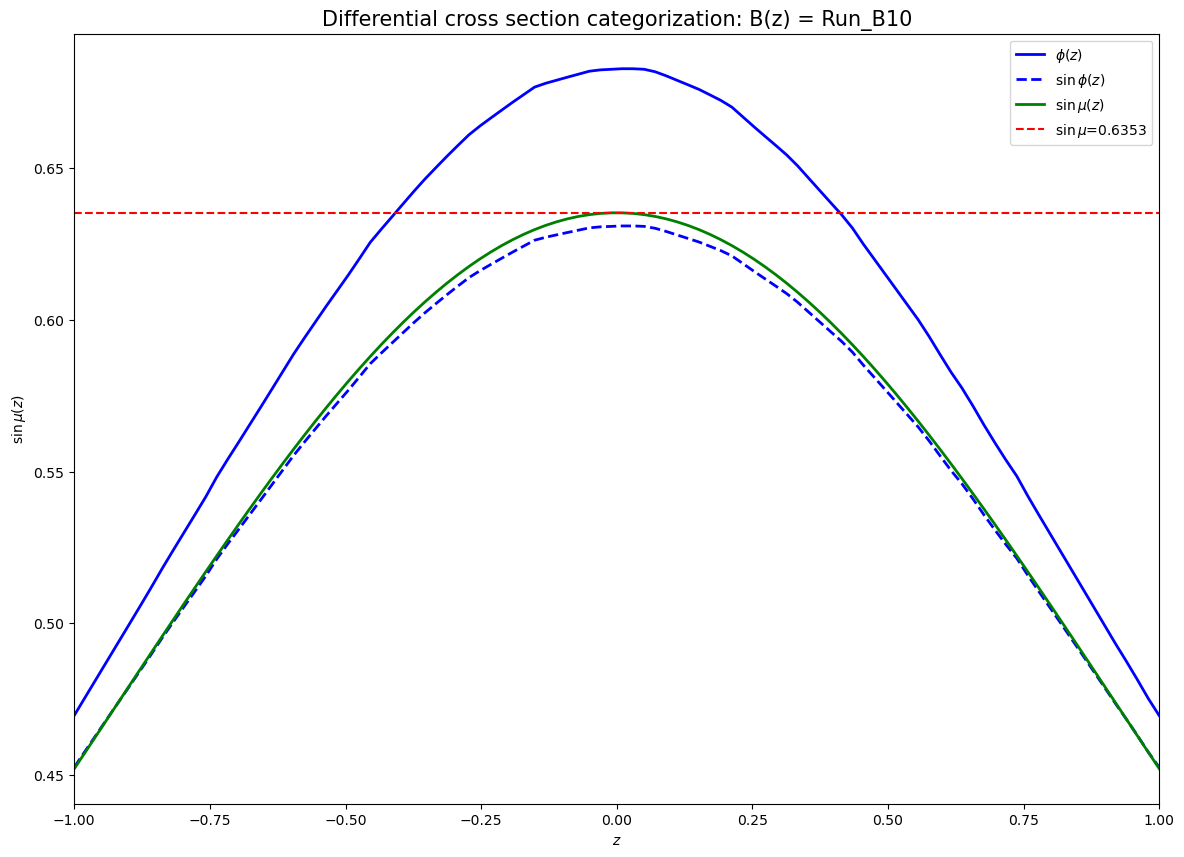

In [159]:
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device, run)

plot_phase(zpointseval, phieval, run)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary(zpointseval, phieval, sinphieval, integralz, run, tags)

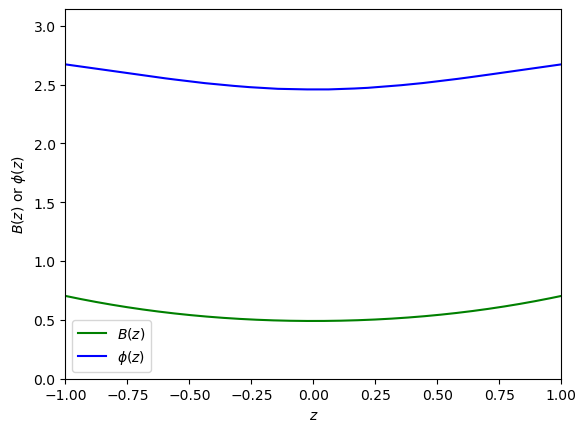

In [230]:
z_pointst = torch.linspace(-1,1,steps=1000, device=device)
net_b = func_Bmin4half_approx(z_pointst.cpu().detach().numpy().astype(np.float64))
with torch.no_grad():      
    phase_b = netsolver.phi_net(z_pointst.view(-1,1))
plt.plot(z_pointst.cpu(), net_b, c='g')
plt.plot(z_pointst.cpu(), math.pi-phase_b.cpu(),c='b')
plt.xlabel('$z$')
plt.legend(['$B(z)$', '$\phi(z)$'])
plt.ylabel('$B(z)$ or $\phi(z)$')    
#plt.title('Boostrap differential cross section : Bmin8', fontsize = 15)
plt.xlim([-1,1])
plt.ylim([0,math.pi])

plt.savefig("/Users/aurelien/Documents/Projects/S-matrix_bootstrap/pictures/Physical_cross_sections/B4half_tot.png")
plt.savefig("/Users/aurelien/Documents/Projects/S-matrix_bootstrap/pictures/Physical_cross_sections/B4half_tot.pdf")
plt.show()

In [170]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-1726


In [224]:
from copy import deepcopy
# Start the Neptune logger run
run2 = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_B102")

params2 = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.001,
         'repulsive_epochs': [0, 1000],
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': True,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

tags = {'constant function': 'Run_B102', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run2["sys/tags"].add(list(tags.values()))

run2['parameters'] = params2

https://app.neptune.ai/zulap/2to2scattering/e/TOS-1732
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [225]:
netsolver2 = train_run(params2, device, run2, seed_num=42, optim_name='Adam', phi_net=deepcopy(netsolver.phi_net))

PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)


  0%|          | 0/5000 [00:00<?, ?epoch/s]

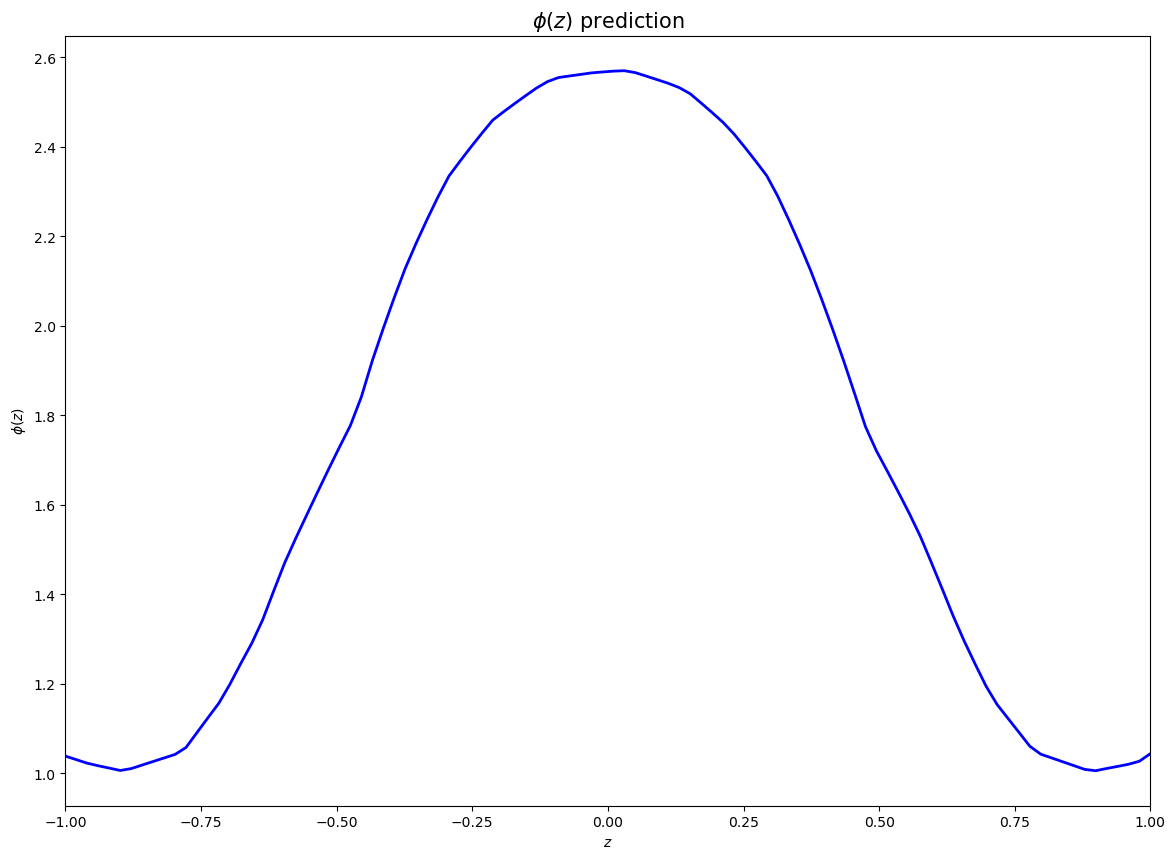

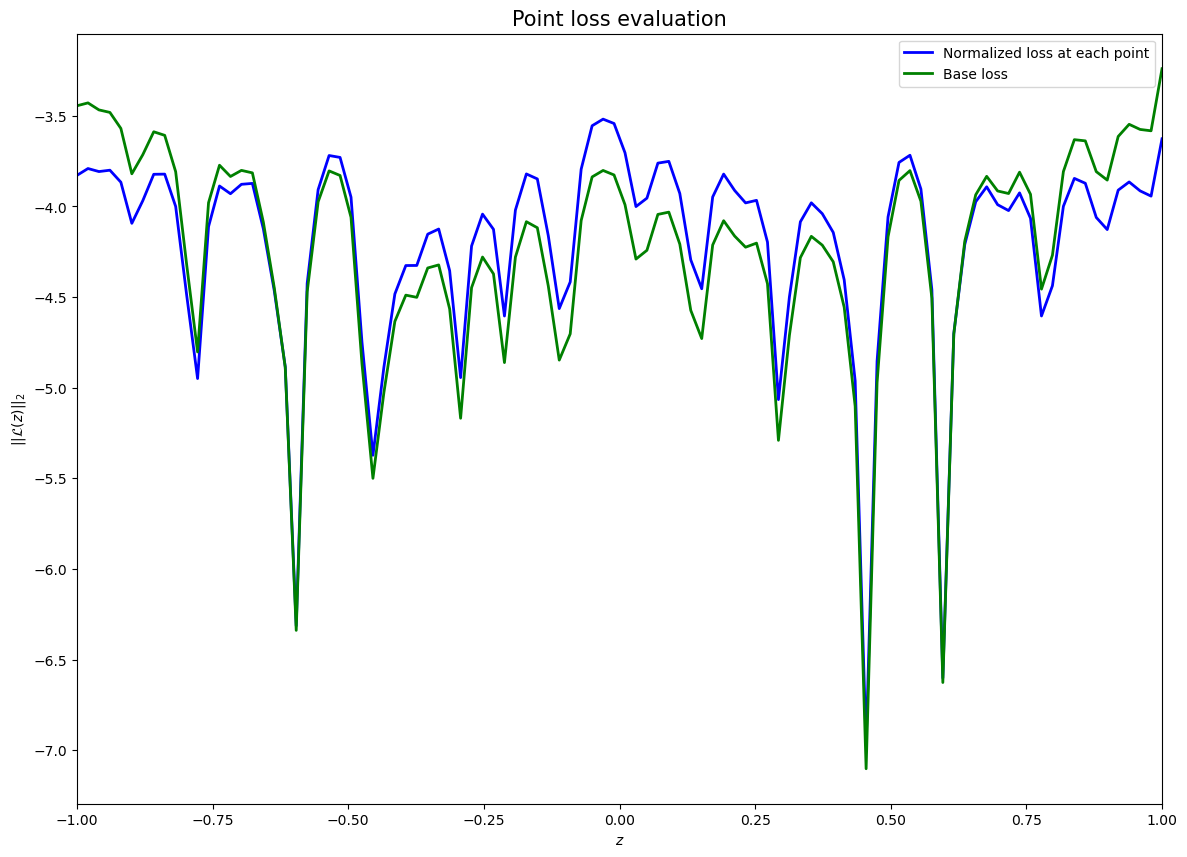

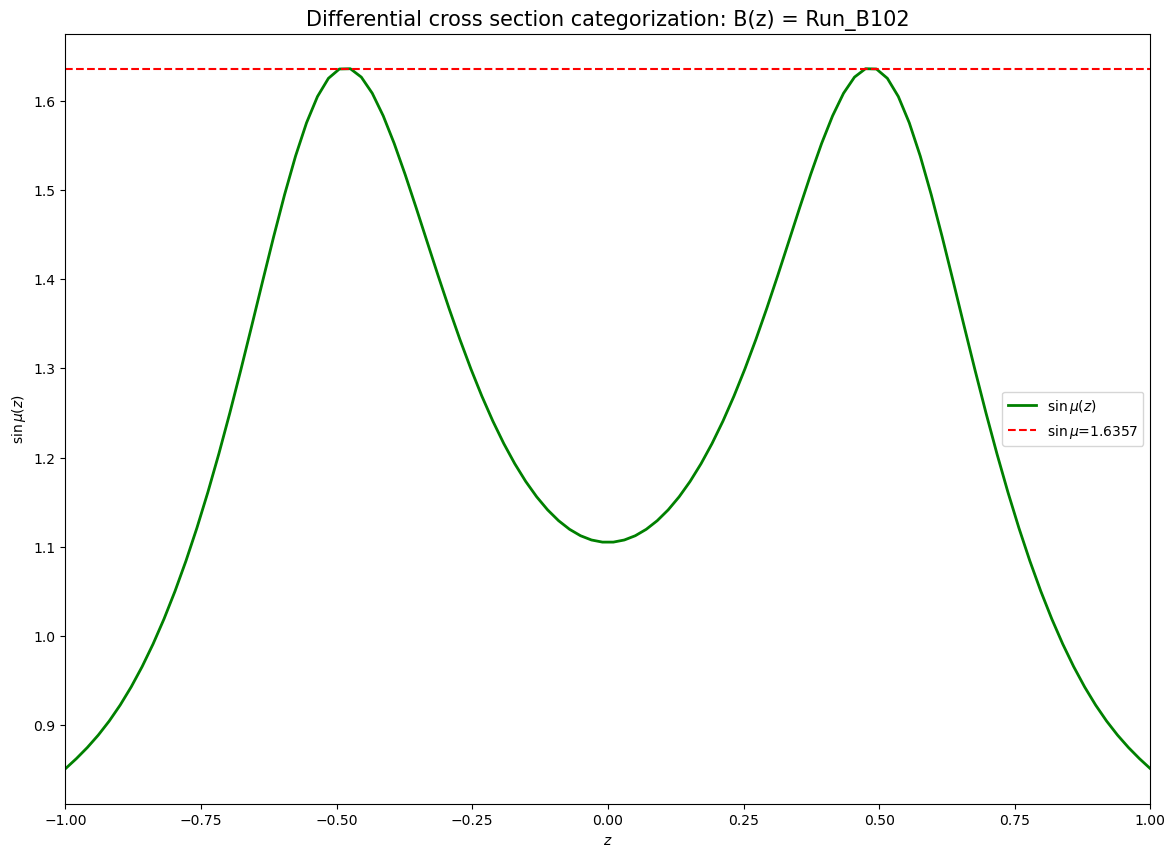

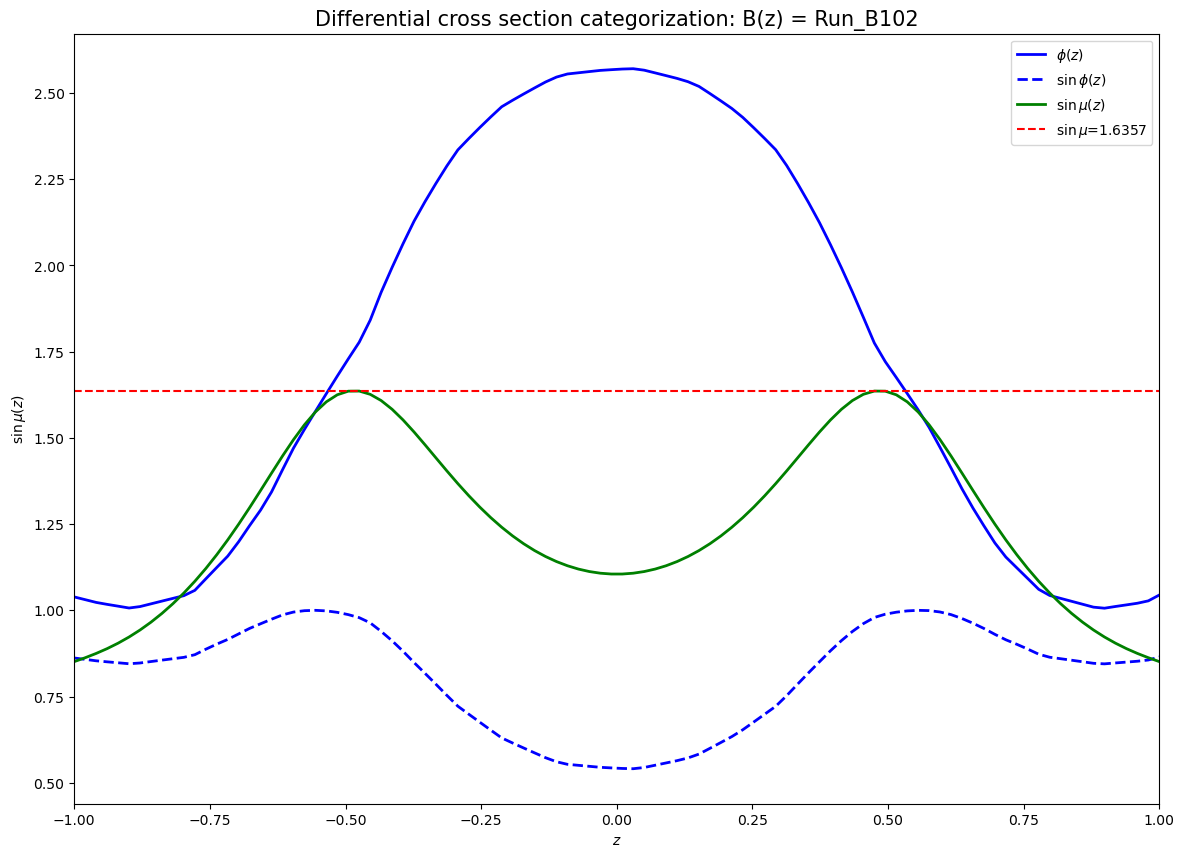

In [226]:
zpointseval2, phieval2, sinphieval2, eval_pt_loss_s2, eval_pt_loss_no_s2 = eval_run(netsolver2, params2, device, run2)

plot_phase(zpointseval2, phieval2, run2)
plot_point_loss(zpointseval2, eval_pt_loss_s2, eval_pt_loss_no_s2, run2)

integralz2 = sin_mu_integral(params2, device, netsolver2, zpointseval2)
plot_sin_mu(zpointseval2, integralz2, tags)

plot_summary(zpointseval2, phieval2, sinphieval2, integralz2, run2, tags)

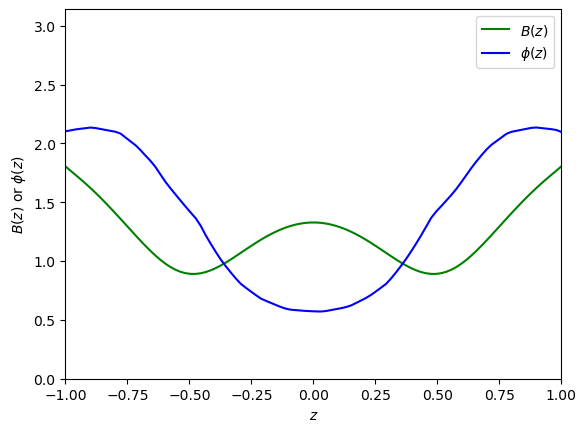

In [228]:
z_pointst = torch.linspace(-1,1,steps=100, device=device)
net_b = func_Bmin8_approx(z_pointst.cpu().detach().numpy().astype(np.float64))
with torch.no_grad():      
    phase_b = netsolver2.phi_net(z_pointst.view(-1,1))
plt.plot(z_pointst.cpu(), net_b, c='g')
plt.plot(z_pointst.cpu(), math.pi-phase_b.cpu(),c='b')
plt.xlabel('$z$')
plt.legend(['$B(z)$', '$\phi(z)$'])
plt.ylabel('$B(z)$ or $\phi(z)$')    
plt.xlim([-1,1])
plt.ylim([0,math.pi])
plt.savefig("/Users/aurelien/Documents/Projects/S-matrix_bootstrap/pictures/Physical_cross_sections/B8_tot.png")
plt.savefig("/Users/aurelien/Documents/Projects/S-matrix_bootstrap/pictures/Physical_cross_sections/B8_tot.pdf")

#plt.title('Boostrap differential cross section : Bmin4+1/2', fontsize = 15)

plt.show()

In [229]:
run2.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-1732


In [43]:
run3 = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_Crichton")

params3 = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': [100, 500],
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Custom_Sigmoid',
         'loss': 'Huber',
         'scaled_loss': False,
         'num_nets' : 2,
         'p_value': 1.0,
         'lambda_repulsive': 1.0}

tags = {'constant function': 'Run_Crichton', 'optimizer': 'Adam', 'Mode': 'Constant param'}
run3["sys/tags"].add(list(tags.values()))

run3['parameters'] = params3

https://app.neptune.ai/zulap/2to2scattering/e/TOS-1780
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [44]:
netsolver3 = train_run(params3, device, run3, seed_num=42, optim_name='Adam')

PhiNet(
  (activation): ReLU()
  (final_layer): Custom_Sigmoid()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Custom_Sigmoid()
  )
)


  0%|          | 0/5000 [00:00<?, ?epoch/s]

In [45]:
run3.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.
All 26 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-1780


In [41]:
def crichton_solutions(zpoints):
    z = zpoints.cpu()
    sol1 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*z*np.sin(869*math.pi/3600))
    sol1 = math.pi - sol1 - 2*math.pi*torch.heaviside(-sol1, torch.tensor(0.0)) + 2*math.pi*torch.heaviside(sol1-2*math.pi, torch.tensor(0.0))
    sol2 = math.pi - torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)+np.exp(659*1j*math.pi/1200)*np.cos(59*math.pi/1200)-3*np.exp(-59*1j*math.pi/400)*z*np.sin(59*math.pi/400))
    
    return sol1, sol2

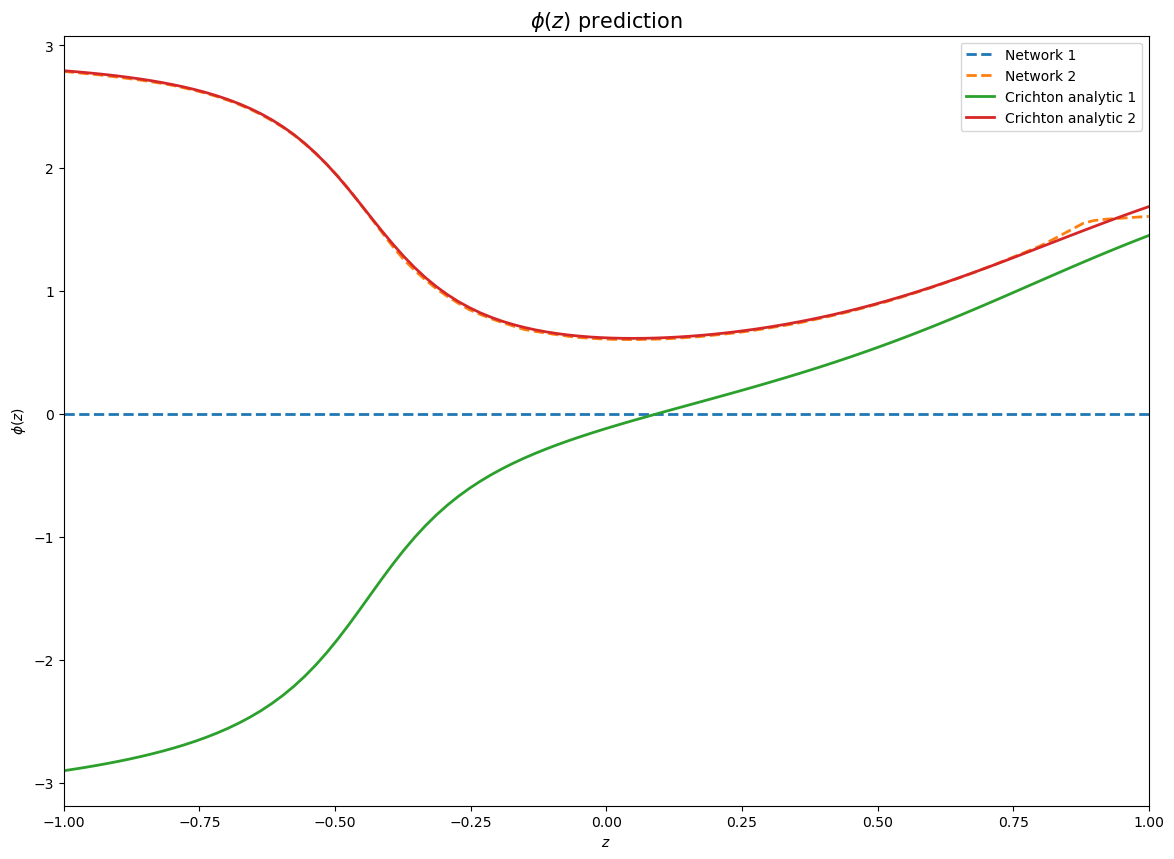

In [46]:
import matplotlib.pyplot as plt

# Make sure we are in evaluation mode
netsolver3.phi_net.eval()
with torch.no_grad(): 

    # Create the evaluation points and compute the phase at those points
    zpointstest = torch.linspace(-1,1,steps=100, device=device)
    phase1 = netsolver3.multi_nets[0](zpointstest.view(-1,1)).squeeze().cpu().numpy()
    phase2 = netsolver3.multi_nets[1](zpointstest.view(-1,1)).squeeze().cpu().numpy()

    
solc1, solc2 = crichton_solutions(zpointstest)
fig = plt.figure(figsize=(14, 10))
    

plt.plot(zpointstest.cpu(),phase1, '--', linewidth = 2)       
plt.plot(zpointstest.cpu(),phase2, '--', linewidth = 2)   
plt.plot(zpointstest.cpu(),solc1, '-', linewidth = 2)   
plt.plot(zpointstest.cpu(),solc2, '-', linewidth = 2)   
plt.xlabel('$z$')
plt.ylabel('$\phi(z)$')    
plt.title('$\phi(z)$ prediction', fontsize = 15)
plt.legend(['Network {}'.format(i+1) for i in range(2)]+['Crichton analytic 1', 'Crichton analytic 2'])
plt.xlim([-1,1])
plt.show()
#run[f'evaluation/two_phases'].upload(File.as_image(fig))
plt.close(fig)
